In [3]:
trace_names = ["conv", "code", "burst", "mixed"]
conv_trace_file = "/mnt/network_drive/lrq/traces/conv/sample_0_all_input1_output1_ids.json"
code_trace_file = "/mnt/network_drive/lrq/traces/code/sample_0_all_input1_output1_ids_upsample_2.json"
burst_trace_file = "/mnt/network_drive/lrq/traces/burst/burst_gpt_1.json"
mixed_trace_file = "/mnt/network_drive/lrq/traces/mixed/mixed.json"

trace_files = [conv_trace_file, code_trace_file, burst_trace_file, mixed_trace_file]

In [4]:
from datetime import datetime
class RequestStatus:
    def __init__(self, arrival_time, prefill_length, decode_length):
        self.arrival_time = arrival_time
        self.prefill_length = prefill_length
        self.decode_length = decode_length

def timestamp_str_to_seconds(ts_str):
    t = datetime.strptime(ts_str, "%H:%M:%S.%f")
    return t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6

In [5]:
import json
from typing import Dict, List

requests_map: Dict[str, List[RequestStatus]] = {}
for i, trace_name in enumerate(trace_names):
    trace_file = trace_files[i]
    requests_map[trace_name] = []
    with open(trace_file, 'r') as f:
        trace_json_data = json.load(f)
        for req_json in trace_json_data[1:]:
            arrival_timestamp = timestamp_str_to_seconds(req_json['timestamp'])
            data = req_json['data']
            prefill_length = len(data['prompt'])
            decode_length = data['max_tokens']
            request_stat = RequestStatus(arrival_time=arrival_timestamp, prefill_length=prefill_length, decode_length=decode_length)
            requests_map[trace_name].append(request_stat)
            

In [9]:
import numpy as np
for i, trace_name in enumerate(trace_names):
    requests = requests_map[trace_name]
    n_requests = len(requests)
    prefill_lengths = [req.prefill_length for req in requests]
    decode_lengths = [req.decode_length for req in requests]
    avg_prefill_length = sum(prefill_lengths) / n_requests
    avg_decode_length = sum(decode_lengths) / n_requests
    print(f"Trace {trace_name} has {n_requests} requests, average prefill length {avg_prefill_length:.1f}, average decode length {avg_decode_length:.1f}. P99 deocode length {np.percentile(decode_lengths, 99)}")

Trace conv has 207715 requests, average prefill length 1656.2, average decode length 102.3. P99 deocode length 661.0
Trace code has 27876 requests, average prefill length 2375.8, average decode length 22.8. P99 deocode length 282.0
Trace burst has 33298 requests, average prefill length 258.8, average decode length 14.2. P99 deocode length 195.0
Trace mixed has 198329 requests, average prefill length 1290.5, average decode length 61.5. P99 deocode length 581.0


In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Assume RequestStatus is already defined and requests_map is populated

def plot_rps_tps(requests_map, bin_size=5):
    for name, requests in requests_map.items():
        # Extract arrival times and prefill tokens
        arrival_times = [r.arrival_time for r in requests]
        prefill_tokens = [r.prefill_length for r in requests]

        # Determine the time range
        min_time = min(arrival_times)
        max_time = max(arrival_times)
        num_bins = int((max_time - min_time) / bin_size) + 1

        # Initialize counters
        rps_bins = np.zeros(num_bins)
        tps_bins = np.zeros(num_bins)

        # Count RPS and TPS per bin
        for t, tokens in zip(arrival_times, prefill_tokens):
            bin_idx = int((t - min_time) / bin_size)
            rps_bins[bin_idx] += 1 / bin_size
            tps_bins[bin_idx] += tokens / bin_size

        # X-axis: time bins
        times = np.arange(num_bins) * bin_size + min_time

        # Plot
        fig, ax1 = plt.subplots()

        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("RPS", color='tab:blue')
        ax1.plot(times, rps_bins, label="RPS", color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        # ax1.set_xlim([0,300])

        ax2 = ax1.twinx()
        ax2.set_ylabel("TPS (prefill)", color='tab:red')
        ax2.plot(times, tps_bins, label="TPS", color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        plt.title(f"RPS & TPS Over Time - {name}")
        fig.tight_layout()
        plt.show()

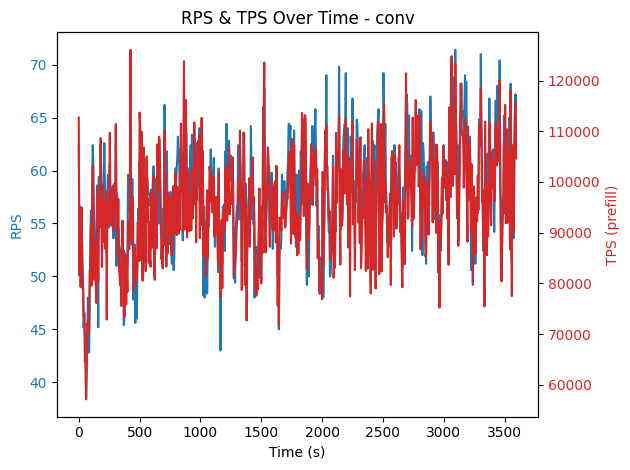

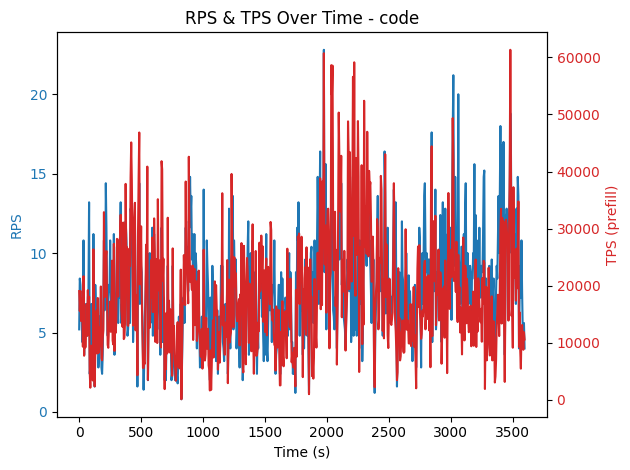

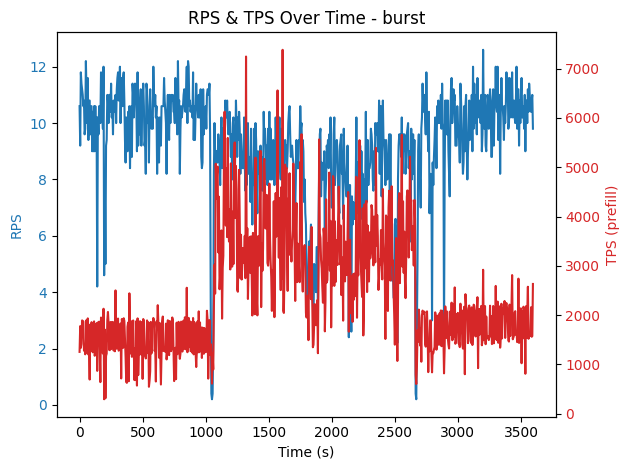

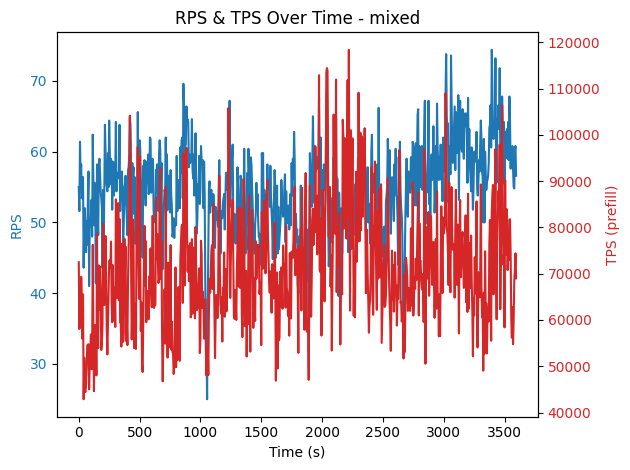

In [8]:
plot_rps_tps(requests_map)